# Take Home Chanllenge

In [59]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import mannwhitneyu

## Part 1 ‐ Exploratory data analysis

In [107]:
login_data = pd.read_json('logins.json')
login_data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [73]:
login_data.set_index('login_time', inplace=True)

In [74]:
interval_login_counts = login_data.resample('15T').size()
interval_login_counts_df = pd.DataFrame(interval_login_counts)
interval_login_counts_df.columns = ['count']
interval_login_counts_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


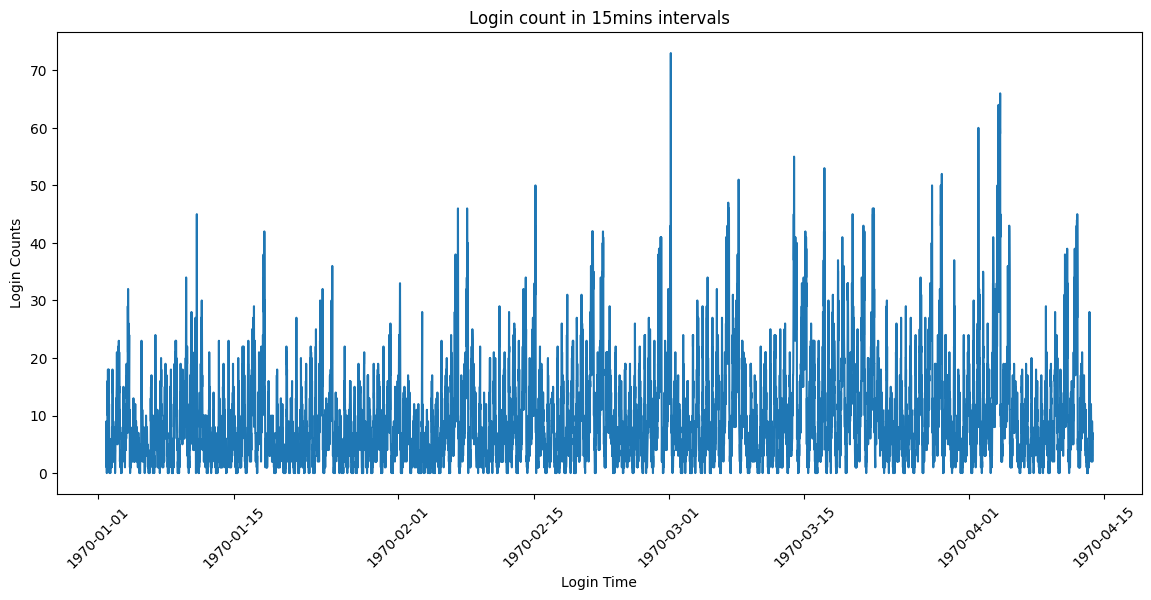

In [75]:
plt.figure(figsize=(14, 6))
plt.plot(interval_login_counts)
plt.title('Login count in 15mins intervals')
plt.xlabel('Login Time')
plt.ylabel('Login Counts')
plt.xticks(rotation=45)
plt.show()

In [84]:
interval_login_counts_df['datetime'] =  pd.to_datetime(interval_login_counts_df.index.to_pydatetime())
interval_login_counts_df['date'] = interval_login_counts_df['datetime'].dt.date
interval_login_counts_df['dayOfWeek'] = interval_login_counts_df['datetime'].dt.day_name()
interval_login_counts_df['hour'] = interval_login_counts_df['datetime'].dt.hour
interval_login_counts_df['time'] = interval_login_counts_df['datetime'].dt.time
interval_login_counts_df.head()

,count,datetime,date,dayOfWeek,hour,time
login_time,,,,,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00,1970-01-01,Thursday,20,20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00,1970-01-01,Thursday,20,20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00,1970-01-01,Thursday,20,20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00,1970-01-01,Thursday,20,20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00,1970-01-01,Thursday,21,21:00:00


In [100]:
daily_cycle = interval_login_counts_df.groupby(['dayOfWeek', 'time'])['count'].mean().unstack(level=0)
daily_cycle.head()

dayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time,,,,,,,
00:00:00,15.800000,8.400000,19.800000,17.333333,15.285714,10.500000,11.285714
00:15:00,17.533333,9.333333,21.933333,18.266667,15.142857,10.785714,12.714286
00:30:00,15.466667,9.600000,20.866667,19.800000,14.428571,11.428571,12.642857
00:45:00,16.200000,8.066667,21.000000,19.466667,13.428571,10.642857,12.428571
01:00:00,17.266667,7.266667,23.800000,18.600000,14.285714,10.285714,14.357143


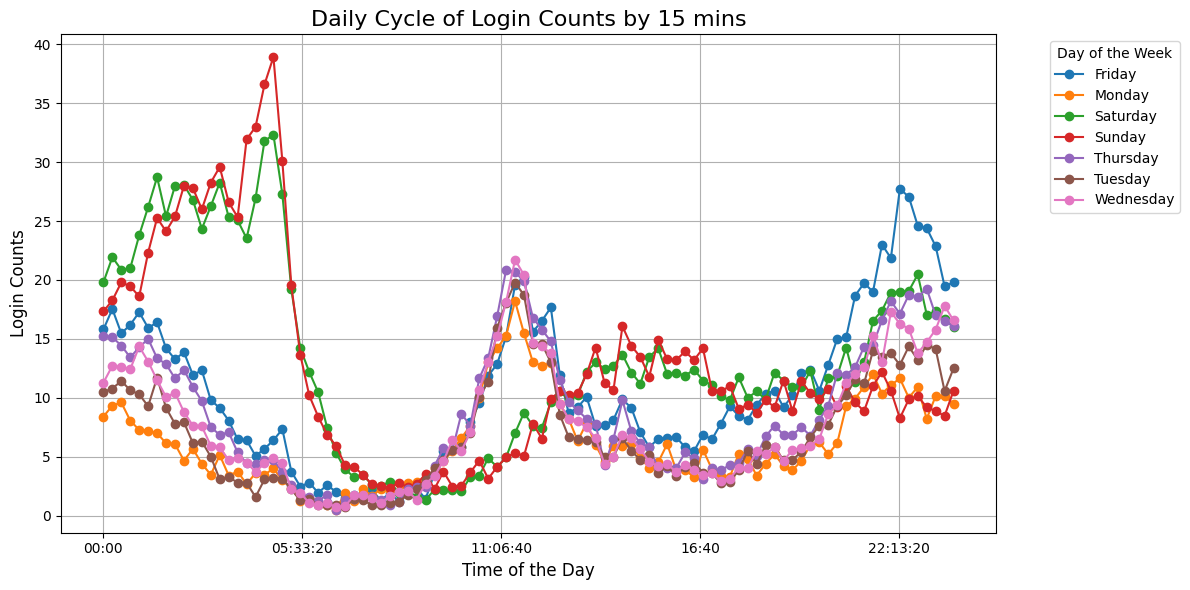

In [106]:
daily_cycle.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Daily Cycle of Login Counts by 15 mins', fontsize=16)
plt.xlabel('Time of the Day', fontsize=12)
plt.ylabel('Login Counts', fontsize=12)
plt.grid(True)
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

The login patterns show distinct differences between weekdays and weekends.

**Weekdays:**
We observe two major spikes in login activity. The first spike occurs around noon, suggesting users are active during the midday, possibly around lunch breaks.
The second noticeable increase in activity happens around 11 PM, likely indicating users logging in during the late evening hours.
After this late evening peak, login activity gradually decreases through the night and early morning.

**Weekends:**
The login pattern differs significantly on weekends. Login activity remains high through the late night, peaking in the early morning between midnight and 5 AM, indicating that users are more active during late-night hours on weekends.
After 5 AM, there is a sharp decline in logins, suggesting reduced activity in the early morning.
However, logins gradually increase again around noon, though the midday spike is less pronounced compared to weekdays.

## Part 2 ‐ Experiment and metrics design

#### 1) Key Measure of Success
Key Metric: Percentage of Drivers Serving Both Cities

This metric directly measures whether toll reimbursement encourages drivers to operate in both Gotham and Metropolis. It is a clear and straightforward indicator of the experiment’s success in breaking down barriers between the cities.

#### 2) Practical Experiment Design

##### a) Implementation of the Experiment:
- Control Group: Drivers continue paying tolls without reimbursement.
- Experimental Group: Drivers receive toll reimbursements for crossing the toll bridge.
- Data Collection: Track driver behavior over several weeks, focusing on the percentage of drivers serving both cities, trip frequency, earnings, and customer wait times.
- Randomization: Randomly assign drivers to groups to ensure fair comparison.
- Baseline: Collect pre-experiment data to compare results.

##### b) Statistical Tests:
- Chi-Square Test: Compare the proportion of drivers serving both cities between the experimental and control groups.
- T-Test or Mann-Whitney U Test: Compare driver earnings and number of cross-city trips between groups.
- Two-Way ANOVA: Analyze interactions between toll reimbursement and time of day/day of the week on cross-city trips.

##### c) Interpreting Results and Recommendations:
- If the experiment succeeds: Recommend continuing toll reimbursement to increase driver flexibility and improve service.
- If partially successful: Suggest additional incentives or easing other barriers.
- If the experiment fails: Recommend exploring other factors influencing driver behavior, such as convenience or familiarity with cities.

## Part 3 ‐ Predictive modeling

In [2]:
def plot_retain_by_category(categoryStr):
    retainedByCategory = data.groupby([categoryStr, 'retained']).size().unstack()
    retentionRate = retainedByCategory[True] / (retainedByCategory[False] + retainedByCategory[True]) * 100
    retainedByCategory.index = retainedByCategory.index.astype(str)
    
    if 'day_of_week' in categoryStr:
        custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    else:
        # Use the natural order of the category (unique values in the column)
        custom_order = retainedByCategory.index.tolist()
    
    fig, ax1 = plt.subplots(figsize=(8, 4))

    retainedByCategory.loc[custom_order].plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_xlabel(categoryStr)
    ax1.set_ylabel('Number of Users')
    ax1.set_title(f"Retention by {categoryStr}")
    plt.xticks(rotation=45)

    ax2 = ax1.twinx()
    ax2.plot(retentionRate.index, retentionRate.values, color='red', marker='o', label='Retention Rate')
    ax2.set_ylabel('Retention Rate (%)')
    ax2.legend(loc='upper right')
               
    plt.show()

In [3]:
def chiSquaredTest(categoryStr):
    contingency_table = pd.crosstab(data[categoryStr], data['retained'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-Squared Statistic: {chi2}")
    print(f"P-Value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected Frequencies:\n{expected}")

    # Interpretation
    if p < 0.05:
        print(f"Reject the null hypothesis: There is a significant difference in retention rates across {categoryStr}.")
    else:
        print(f"Fail to reject the null hypothesis: No significant difference in retention rates across {categoryStr}.")


### Data Wrangling

In [4]:
data = pd.read_json('ultimate_data_challenge.json')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### Handle missing values

In [6]:
data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [7]:
data[data.isnull().any(axis=1)].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0


In [8]:
data.avg_rating_of_driver.unique(), data.avg_rating_by_driver.unique()

(array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, nan, 4.5, 4. , 3.9, 4.9, 4.8, 2.5,
        3.7, 1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2,
        2.6, 3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2]),
 array([5. , 4.9, 4. , 3. , 4.8, 4.7, 4.5, 4.2, nan, 4.4, 4.6, 3.7, 4.3,
        3.5, 2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8,
        1.5, 2.7]))

Users with only a few trips tend to have incomplete rating data (both in terms of providing ratings and receiving them). Because ratings can vary significantly, using the mean or median to fill in missing values could misrepresent actual user behavior. Instead, since ratings are on a scale from 1 to 5, a value of 0 will be used to indicate the absence of rating data, clearly distinguishing users who haven't been rated from those who have.

In [9]:
data.avg_rating_of_driver = data.avg_rating_of_driver.fillna(0)
data.avg_rating_by_driver = data.avg_rating_by_driver.fillna(0)

For missing phone numbers, to avoid misrepresenting the actual user profile, the value will be filled with the string "Unknown."

In [10]:
data.phone = data.phone.fillna("Unknown")

In [11]:
data.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

#### Drop duplicates

In [12]:
data[data.duplicated(keep=False)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
332,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
3134,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0
5958,Winterfell,1,2014-01-18,0.0,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
7836,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
10624,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0
14990,Winterfell,1,2014-01-18,0.0,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
26709,Winterfell,1,2014-01-01,0.0,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0


In [13]:
data = data.drop_duplicates()
data[data.duplicated(keep=False)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


#### Correct data type

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49992 non-null  object 
 1   trips_in_first_30_days  49992 non-null  int64  
 2   signup_date             49992 non-null  object 
 3   avg_rating_of_driver    49992 non-null  float64
 4   avg_surge               49992 non-null  float64
 5   last_trip_date          49992 non-null  object 
 6   phone                   49992 non-null  object 
 7   surge_pct               49992 non-null  float64
 8   ultimate_black_user     49992 non-null  bool   
 9   weekday_pct             49992 non-null  float64
 10  avg_dist                49992 non-null  float64
 11  avg_rating_by_driver    49992 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [15]:
data.city = data.city.astype('category')
data.signup_date = pd.to_datetime(data.signup_date)
data.last_trip_date = pd.to_datetime(data.last_trip_date)
data.phone = data.phone.astype('string')
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49992 non-null  category      
 1   trips_in_first_30_days  49992 non-null  int64         
 2   signup_date             49992 non-null  datetime64[ns]
 3   avg_rating_of_driver    49992 non-null  float64       
 4   avg_surge               49992 non-null  float64       
 5   last_trip_date          49992 non-null  datetime64[ns]
 6   phone                   49992 non-null  string        
 7   surge_pct               49992 non-null  float64       
 8   ultimate_black_user     49992 non-null  bool          
 9   weekday_pct             49992 non-null  float64       
 10  avg_dist                49992 non-null  float64       
 11  avg_rating_by_driver    49992 non-null  float64       
dtypes: bool(1), category(1), datetime64[ns](2), float64

### EDA

In [16]:
data['retained'] = data['trips_in_first_30_days'] >0
data['signup_day_of_week'] = data.signup_date.dt.day_name()
data['signup_month'] = data.signup_date.dt.month
data['last_trip_day_of_week'] = data.last_trip_date.dt.day_name()
data['last_trip_month'] = data.last_trip_date.dt.month
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,signup_day_of_week,signup_month,last_trip_day_of_week,last_trip_month
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,Saturday,1,Tuesday,6
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,Wednesday,1,Monday,5
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,True,Monday,1,Tuesday,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,Friday,1,Sunday,6
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,True,Monday,1,Saturday,3


#### Variable distributions

/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


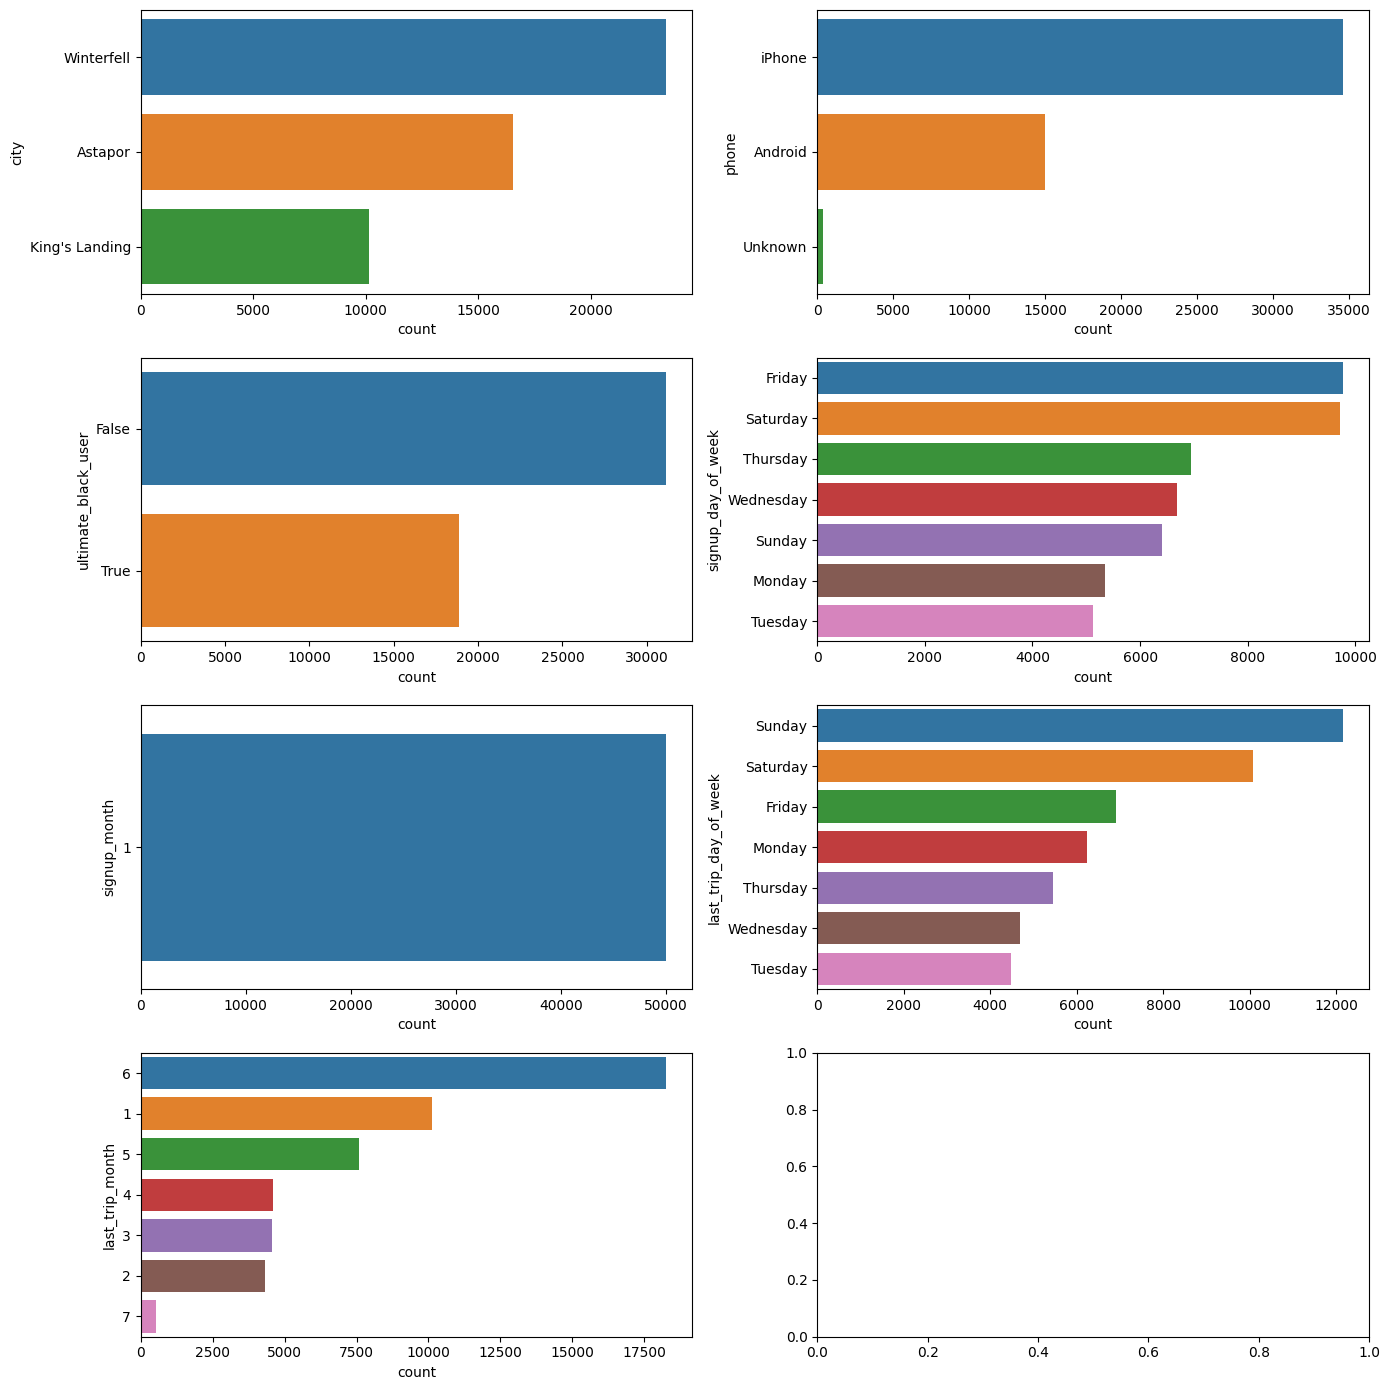

In [17]:
categorical_cols = ['city', 'phone', 'ultimate_black_user', 'signup_day_of_week', 'signup_month', 'last_trip_day_of_week', 'last_trip_month']

fig, axes = plt.subplots(4,2, figsize=(14,14))

for idx, col in enumerate(categorical_cols):
    row_idx = idx // 2
    col_idx = idx % 2
    sns.countplot(data=data, y=col,  ax=axes[row_idx, col_idx], order = data[col].value_counts().index)


plt.tight_layout()
plt.show()

In [18]:
num_cols = data.select_dtypes(include=['int64', 'float64'])

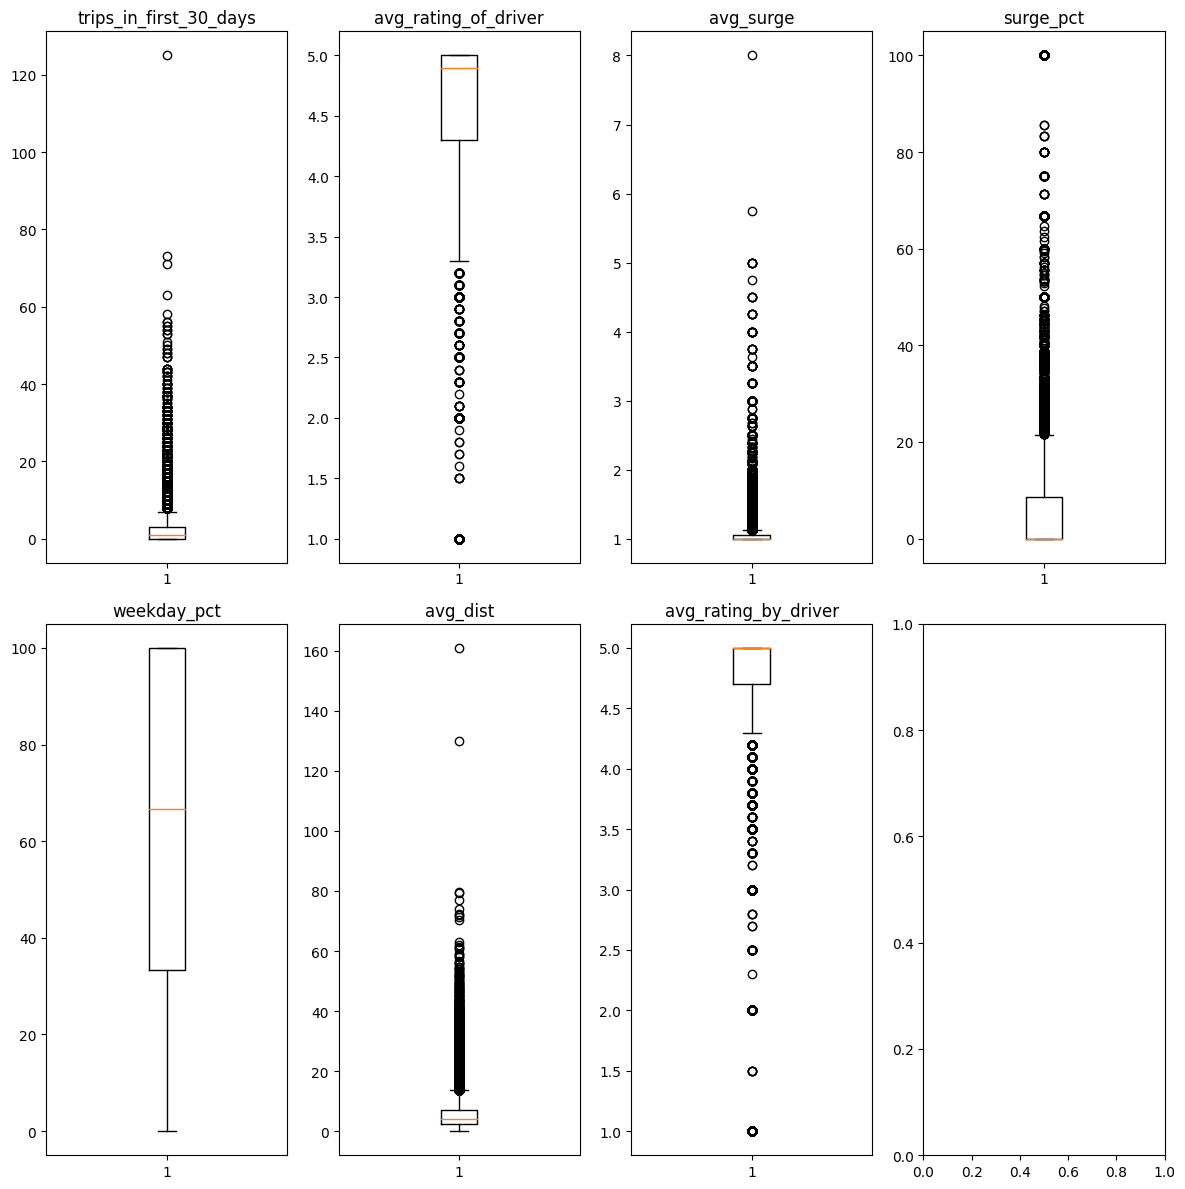

In [19]:
fig, axes = plt.subplots(2,4, figsize=(12,12))

for idx, col in enumerate(num_cols):
    row_idx = idx // 4
    col_idx = idx % 4
    if (col == 'avg_rating_of_driver') or (col == 'avg_rating_by_driver'):
        axes[row_idx, col_idx].boxplot(data[data[col] > 0][col])
    else:
        axes[row_idx, col_idx].boxplot(data[col])
    axes[row_idx, col_idx].set_title(col)


plt.tight_layout()
plt.show()

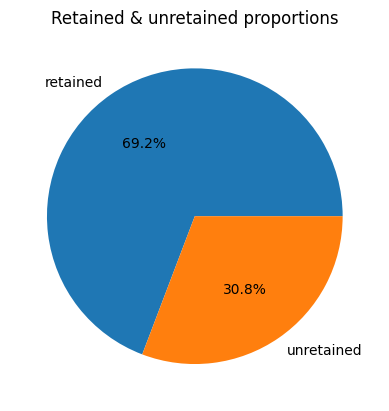

In [20]:
plt.pie([data.retained.sum(), len(data) - data.retained.sum()], labels=['retained', 'unretained'], autopct='%1.1f%%')
plt.title('Retained & unretained proportions')
plt.show()

#### Retention by category

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_19401/815946400.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retainedByCategory = data.groupby([categoryStr, 'retained']).size().unstack()


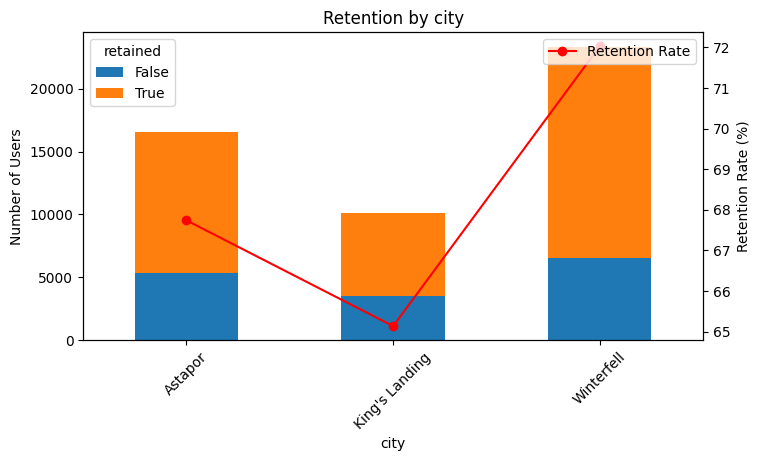

In [21]:
# Retain by city
plot_retain_by_category('city')

In [22]:
chiSquaredTest('city')

Chi-Squared Statistic: 183.0452766615865
P-Value: 1.7874059681446753e-40
Degrees of Freedom: 2
Expected Frequencies:
[[ 5089.05604897 11441.94395103]
 [ 3118.51296207  7011.48703793]
 [ 7182.43098896 16148.56901104]]
Reject the null hypothesis: There is a significant difference in retention rates across city.


Among the three cities, Winterfell has both the highest retention rate and the largest number of retained users, while King's Landing has the lowest retention rate and the fewest retained users.

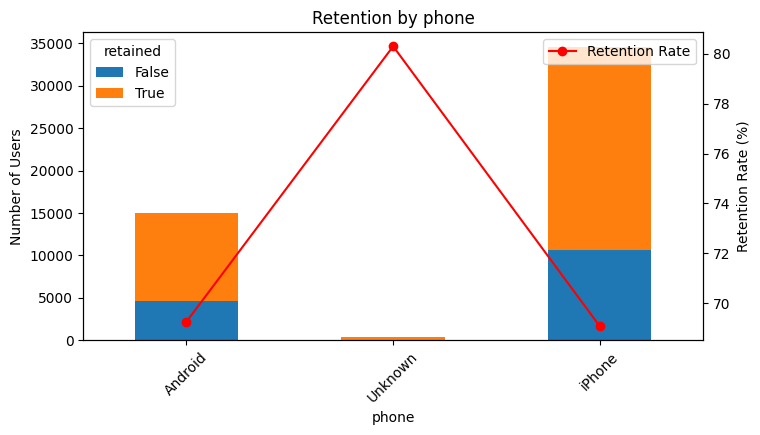

In [23]:
# Retain by phone
plot_retain_by_category('phone')

In [24]:
chiSquaredTest('phone')

Chi-Squared Statistic: 23.202788927086132
P-Value: 9.153314868785654e-06
Degrees of Freedom: 2
Expected Frequencies:
[[ 4623.28012482 10394.71987518]
 [  121.90830533   274.09169467]
 [10644.81156985 23933.18843015]]
Reject the null hypothesis: There is a significant difference in retention rates across phone.


Android and iPhone have similar retention rates, but the iPhone has a larger user base.

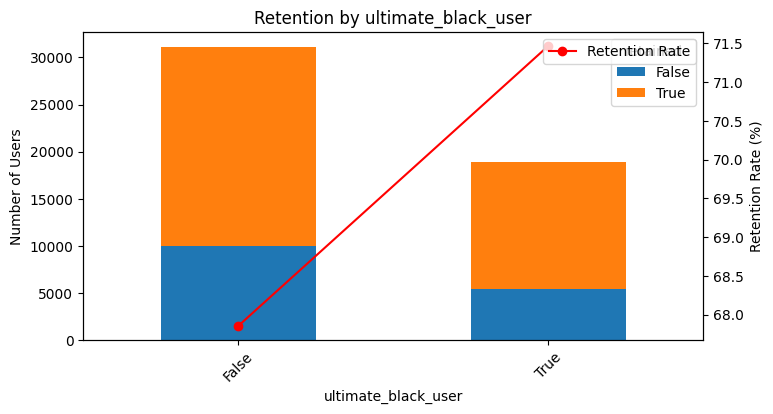

In [25]:
# Retain by ultimate black user
plot_retain_by_category('ultimate_black_user')

In [26]:
chiSquaredTest('ultimate_black_user')

Chi-Squared Statistic: 71.77077646313903
P-Value: 2.4170553240423625e-17
Degrees of Freedom: 1
Expected Frequencies:
[[ 9586.73367739 21554.26632261]
 [ 5803.26632261 13047.73367739]]
Reject the null hypothesis: There is a significant difference in retention rates across ultimate_black_user.


While the retention rate is higher for Ultimate Black users, the non-Ultimate Black users have a larger overall user base, resulting in a greater number of retained users overall.

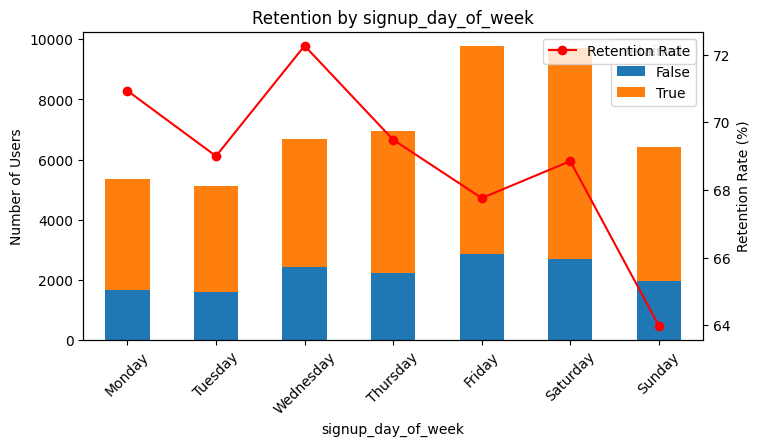

In [27]:
# Retain by signup day of week
plot_retain_by_category('signup_day_of_week')

In [28]:
chiSquaredTest('signup_day_of_week')

Chi-Squared Statistic: 148.95703386398174
P-Value: 1.2855353460339937e-29
Degrees of Freedom: 6
Expected Frequencies:
[[3006.45583293 6759.54416707]
 [1644.53072492 3697.46927508]
 [2990.75552088 6724.24447912]
 [1974.23727796 4438.76272204]
 [2138.01308209 4806.98691791]
 [1577.41958713 3546.58041287]
 [2058.58797408 4628.41202592]]
Reject the null hypothesis: There is a significant difference in retention rates across signup_day_of_week.


Retention rates tend to be higher for users who sign up on weekdays and lower on weekends, particularly on Sunday. The overall user base is largest for those who sign up on Friday and Saturday, leading to the highest number of retained users for sign-ups on those two days.

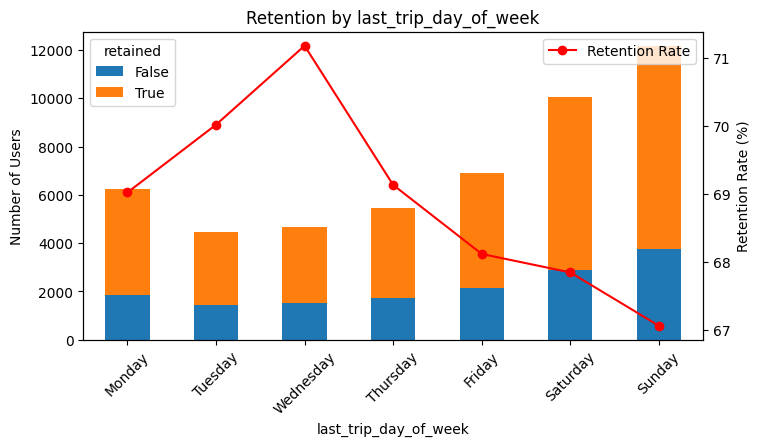

In [29]:
# Retain by last trip day of week, month
plot_retain_by_category('last_trip_day_of_week')

In [30]:
chiSquaredTest('last_trip_day_of_week')

Chi-Squared Statistic: 37.46510903007926
P-Value: 1.428912074305831e-06
Degrees of Freedom: 6
Expected Frequencies:
[[2126.31481037 4780.68518963]
 [1919.74795967 4316.25204033]
 [3101.27340374 6972.72659626]
 [3740.36845895 8409.63154105]
 [1680.85693711 3779.14306289]
 [1379.4725156  3101.5274844 ]
 [1441.96591455 3242.03408545]]
Reject the null hypothesis: There is a significant difference in retention rates across last_trip_day_of_week.


Retention rates tend to be higher for users who took their last trip on weekdays and lower on weekends, particularly on Sunday. However, more people took their last trip on Saturday and Sunday, leading to the highest number of retained users for those whose last trip occurred over the weekend.

#### Retention by numerical features

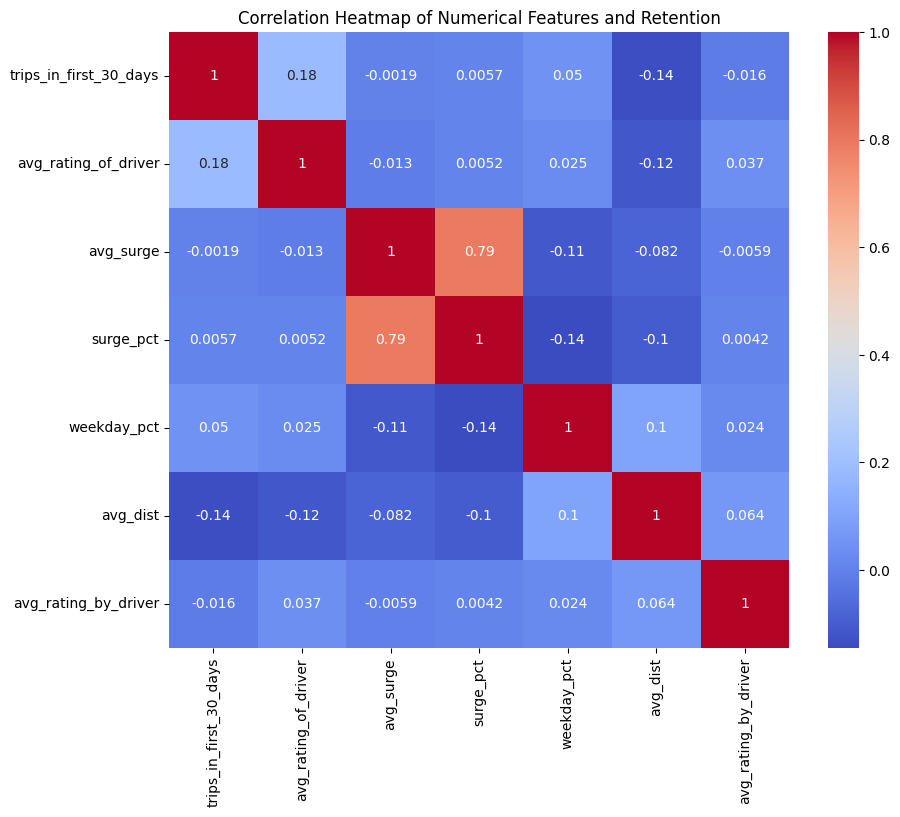

In [32]:
corr_matrix = num_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features and Retention')
plt.show()

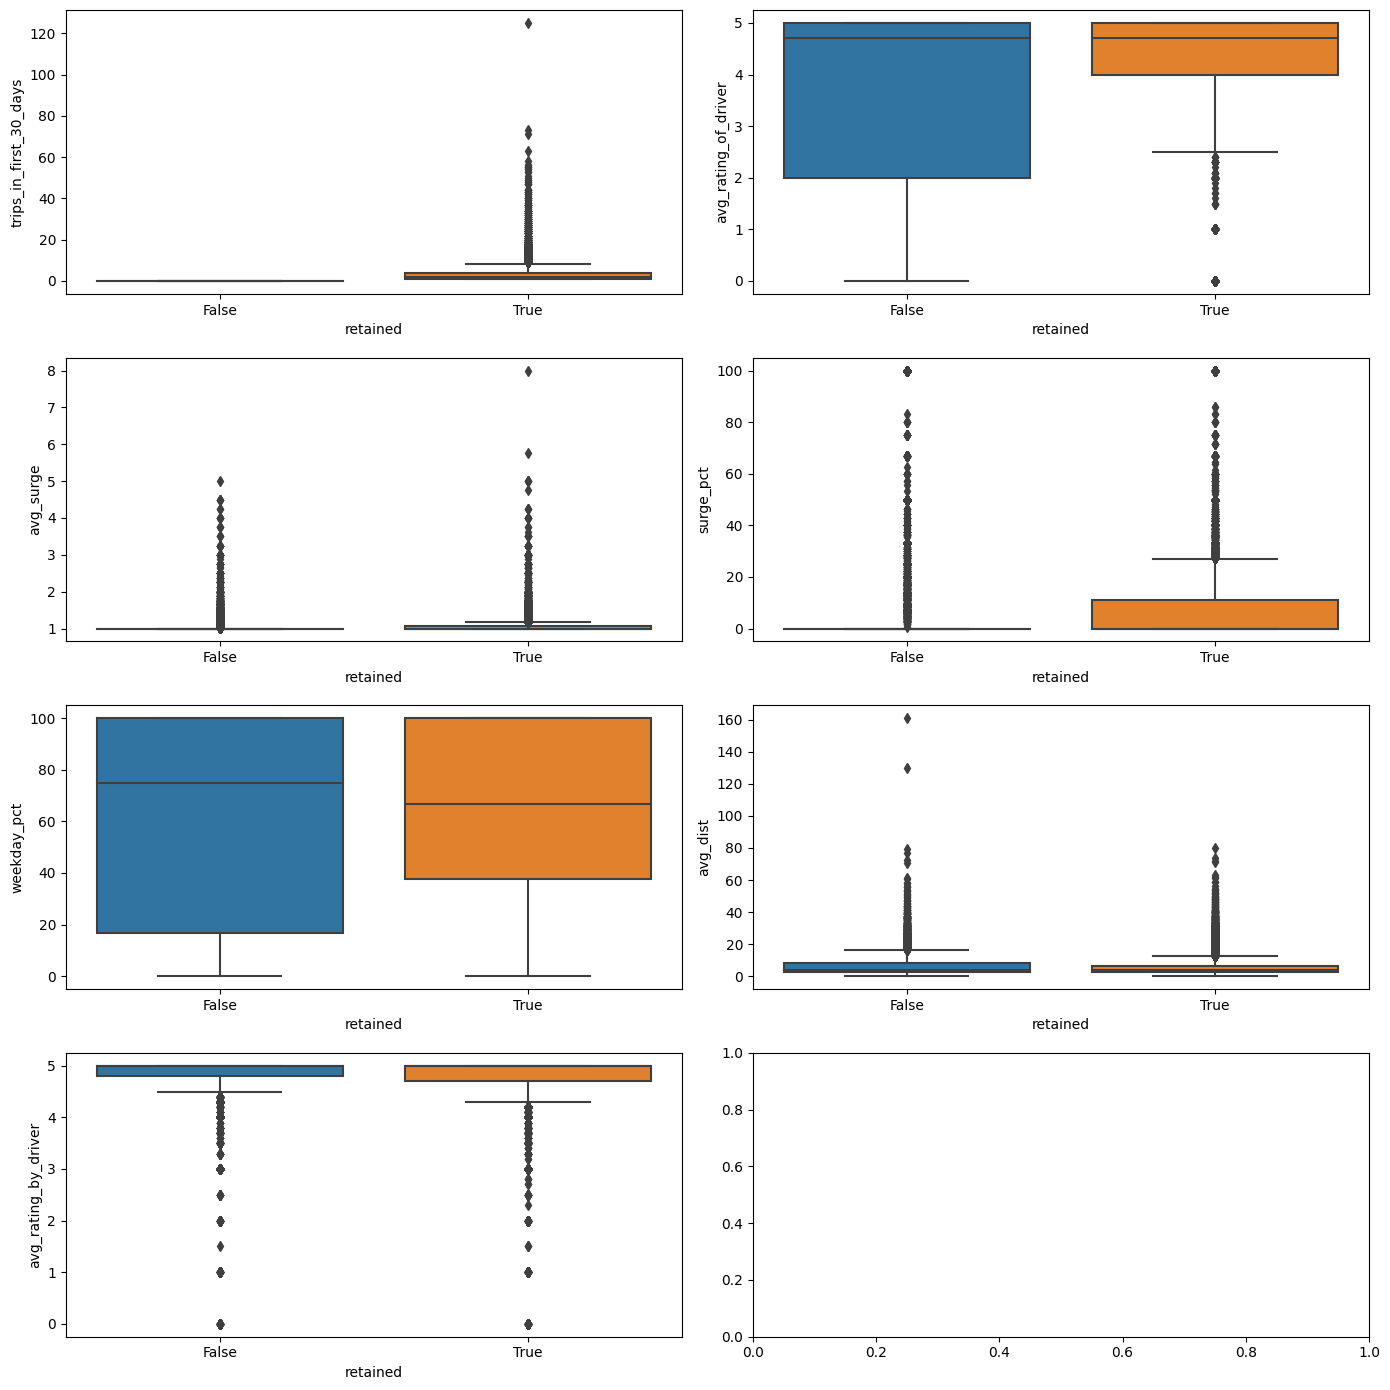

In [46]:
fig, axes = plt.subplots(4,2, figsize=(14,14))

for idx, col in enumerate(num_cols.columns):
    row_idx = idx // 2
    col_idx = idx % 2
    sns.boxplot(x='retained', y=col, data=data, ax=axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


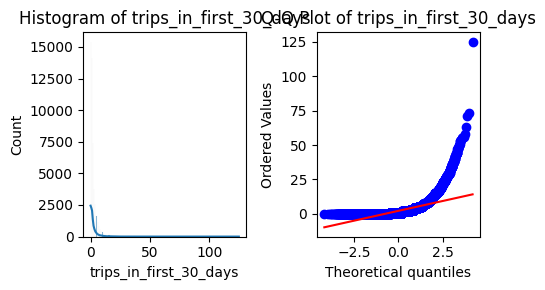

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


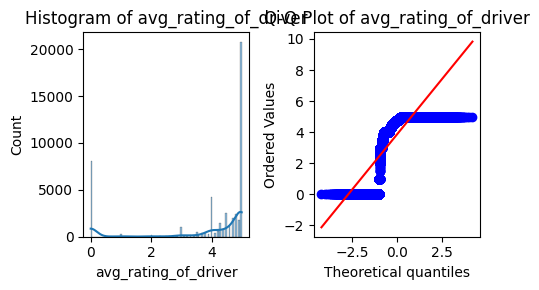

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


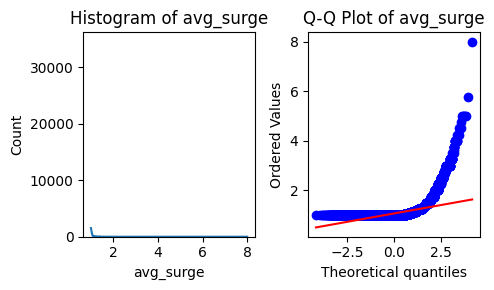

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


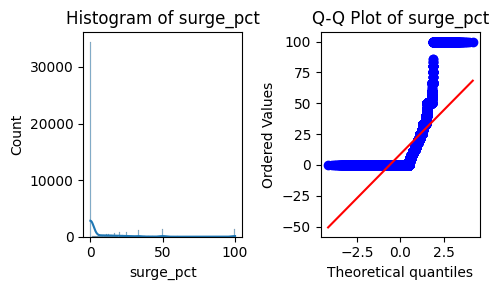

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


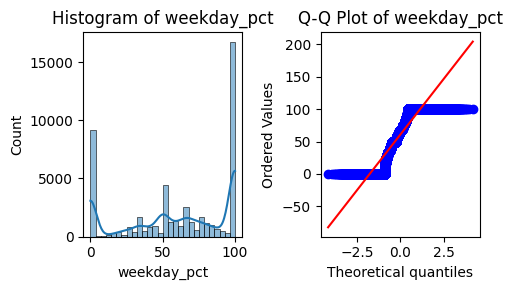

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


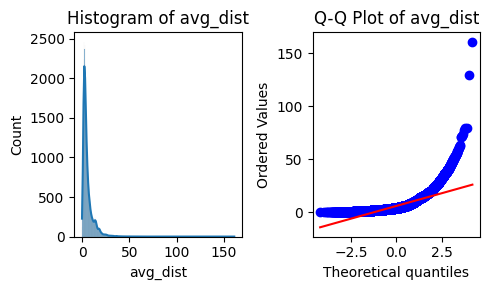

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


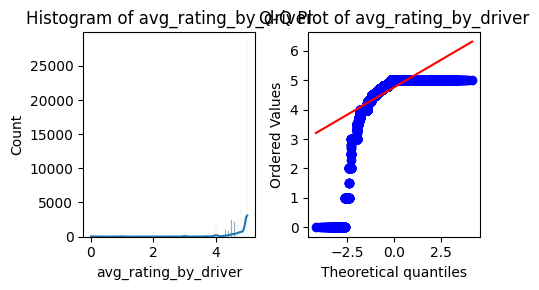

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in num_cols.columns:
    # Histogram
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Histogram of {feature}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {feature}')
    
    plt.tight_layout()
    plt.show()

In [62]:
# Run Mann-Whitney U Test because data not normaly distributed

for feature in num_cols.columns:
    retained = data[data['retained'] == True][feature]
    not_retained = data[data['retained'] == False][feature]

    u_stat, p_value = mannwhitneyu(retained, not_retained)
    print(f"{feature} - U-statistic: {u_stat}, P-value: {p_value}")

trips_in_first_30_days - U-statistic: 532524780.0, P-value: 0.0
avg_rating_of_driver - U-statistic: 276908357.5, P-value: 1.011487376281638e-13
avg_surge - U-statistic: 301992487.5, P-value: 5.229137342236351e-188
surge_pct - U-statistic: 300450496.0, P-value: 5.478538809103159e-172
weekday_pct - U-statistic: 252424969.5, P-value: 2.0808988283862822e-21
avg_dist - U-statistic: 253599046.5, P-value: 1.8654839288510667e-17
avg_rating_by_driver - U-statistic: 226220044.5, P-value: 2.7245712015333444e-195


### Modeling

Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

### Recommendation for imporovement